We first import the necessary libraries and fetch the dataset. We then split the data into training and testing sets.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

# fetch dataset
phishing_websites = fetch_ucirepo(id=327)

# data (as pandas dataframes)
X = phishing_websites.data.features
y = phishing_websites.data.targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7738, 30) (3317, 30) (7738, 1) (3317, 1)


We then train a decision tree classifier and visualize the tree.

We first train a decision tree classifier with a maximum depth of 3 and visualize the tree and calculate the accuracy of the prediction.

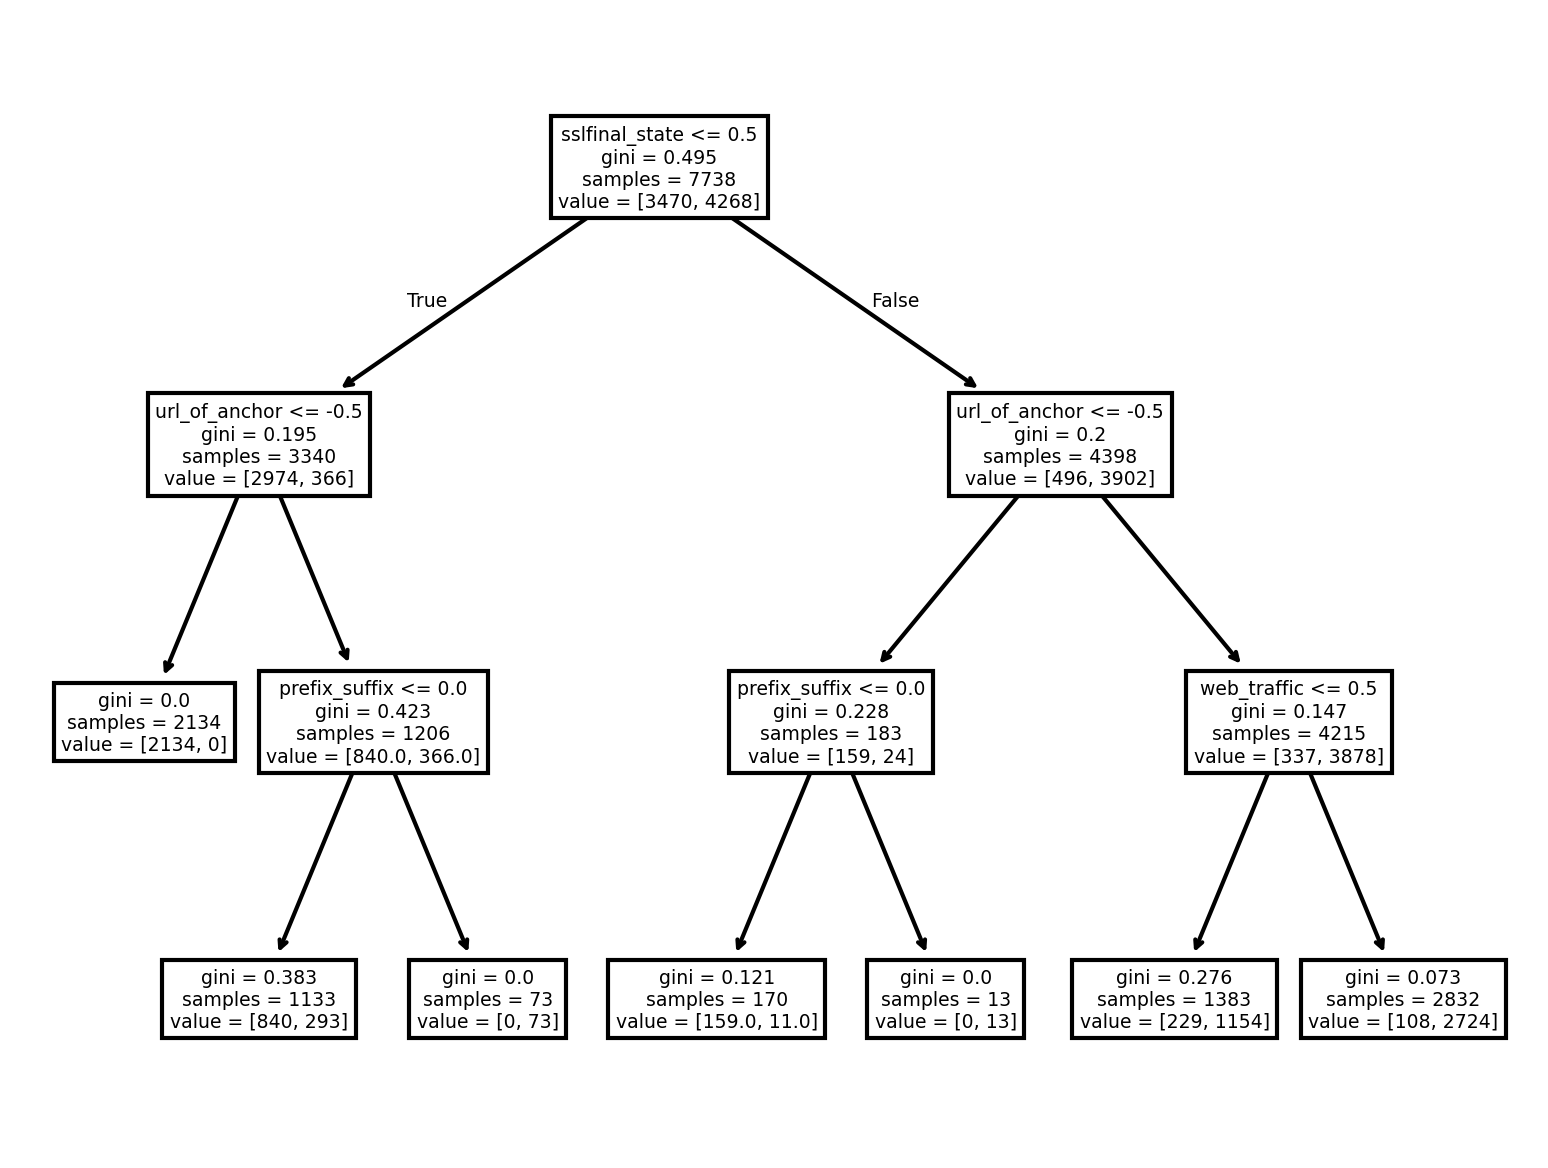

[[-1]
 [-1]
 [-1]
 ...
 [ 1]
 [ 1]
 [ 1]]
[-1 -1 -1 ...  1  1  1]


0.9170937594211637

In [38]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree

model_pruned = DecisionTreeClassifier(random_state=42, max_depth=3)
model_pruned.fit(X_train, y_train)

plot_tree(model_pruned, feature_names=X_train.keys())
plt.show()

print(y_test.values)
prediction_pruned = model_pruned.predict(X_test)
print(prediction_pruned)

accuracy_score(y_test, prediction_pruned)

We then train a decision tree classifier with a cost complexity pruning alpha of 0.012 and visualize the tree and calculate the accuracy of the prediction.

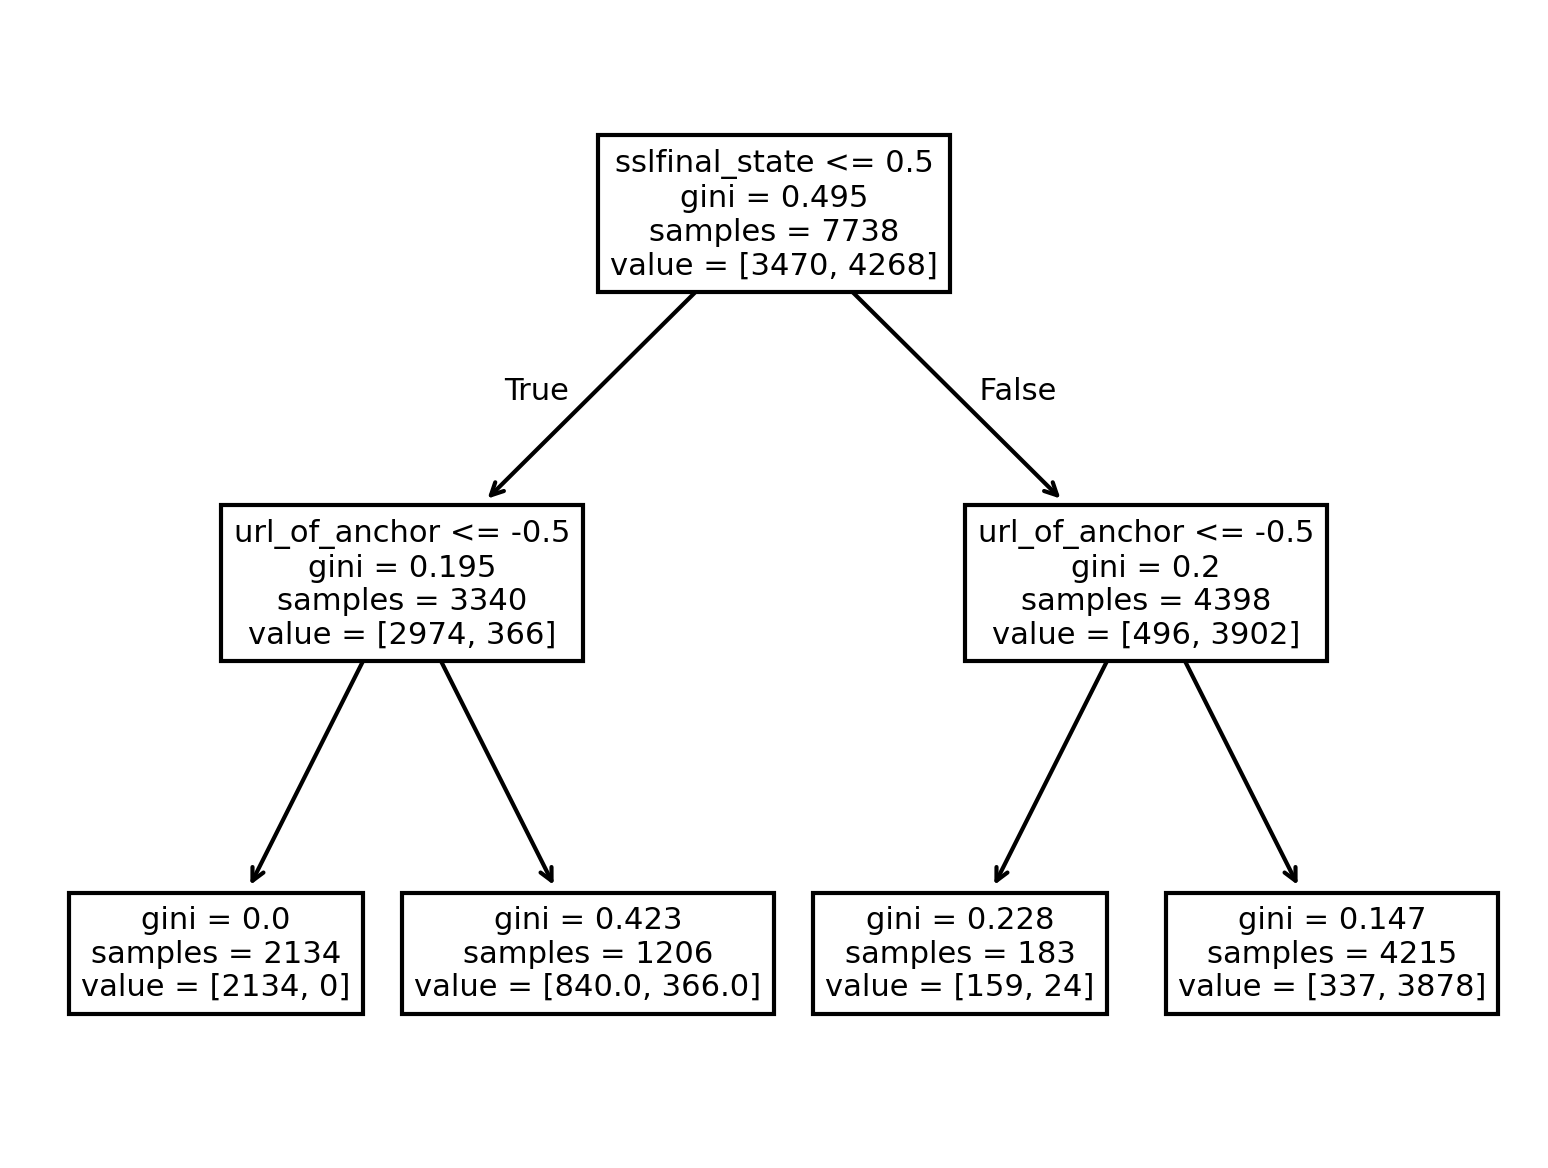

[[-1]
 [-1]
 [-1]
 ...
 [ 1]
 [ 1]
 [ 1]]
[-1 -1 -1 ...  1  1  1]


0.9068435333132349

In [39]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier(random_state=42, ccp_alpha=0.012)
model.fit(X_train, y_train)

plot_tree(model, feature_names=X_train.keys())
plt.show()

print(y_test.values)
prediction = model.predict(X_test)
print(prediction)

accuracy_score(y_test, prediction)


From the two different decision tree classifiers, we can see that the first classifier with a maximum depth of 3 has an accuracy of 0.9116, while the second classifier with a cost complexity pruning alpha of 0.012 has an accuracy of 0.9068. The two classifiers have similar accuracy, but the second classifier has a more complex tree structure.

We will use the second classifier with a cost complexity pruning alpha of 0.012 for further analysis.

## Guidelines

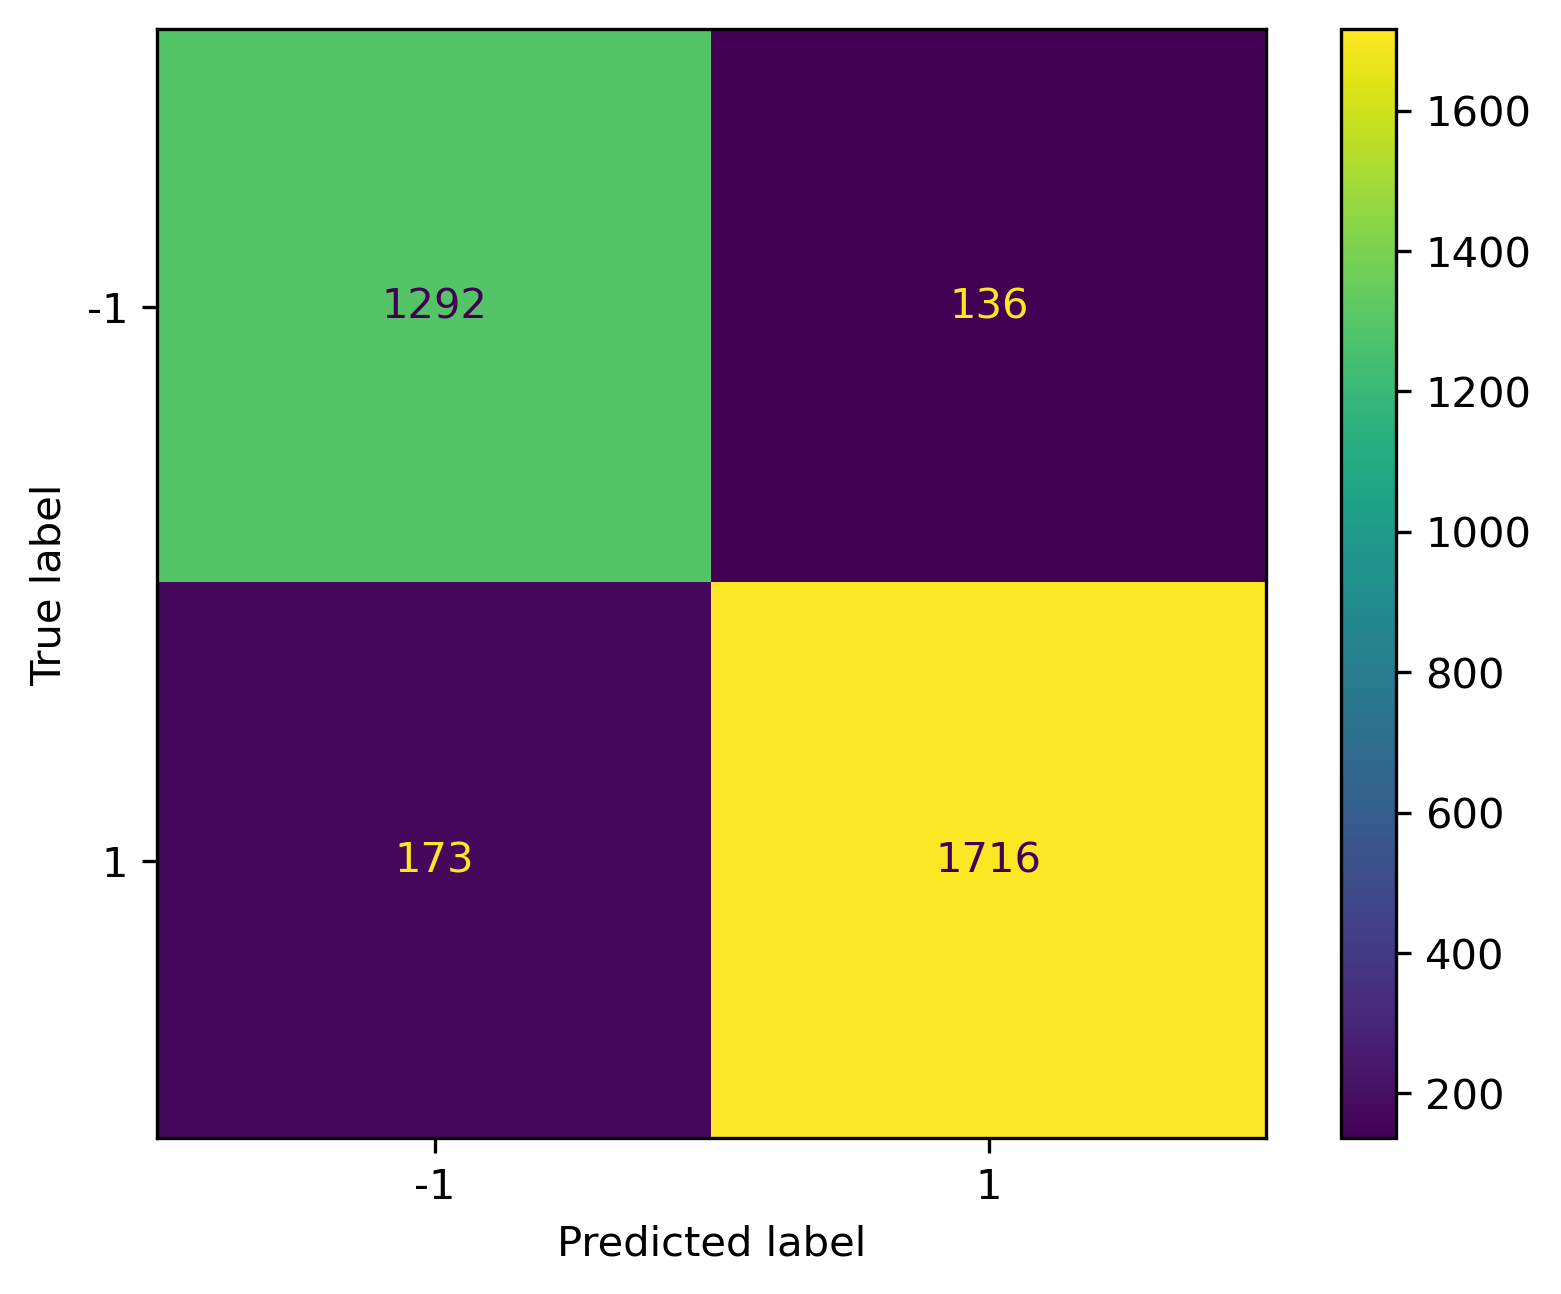

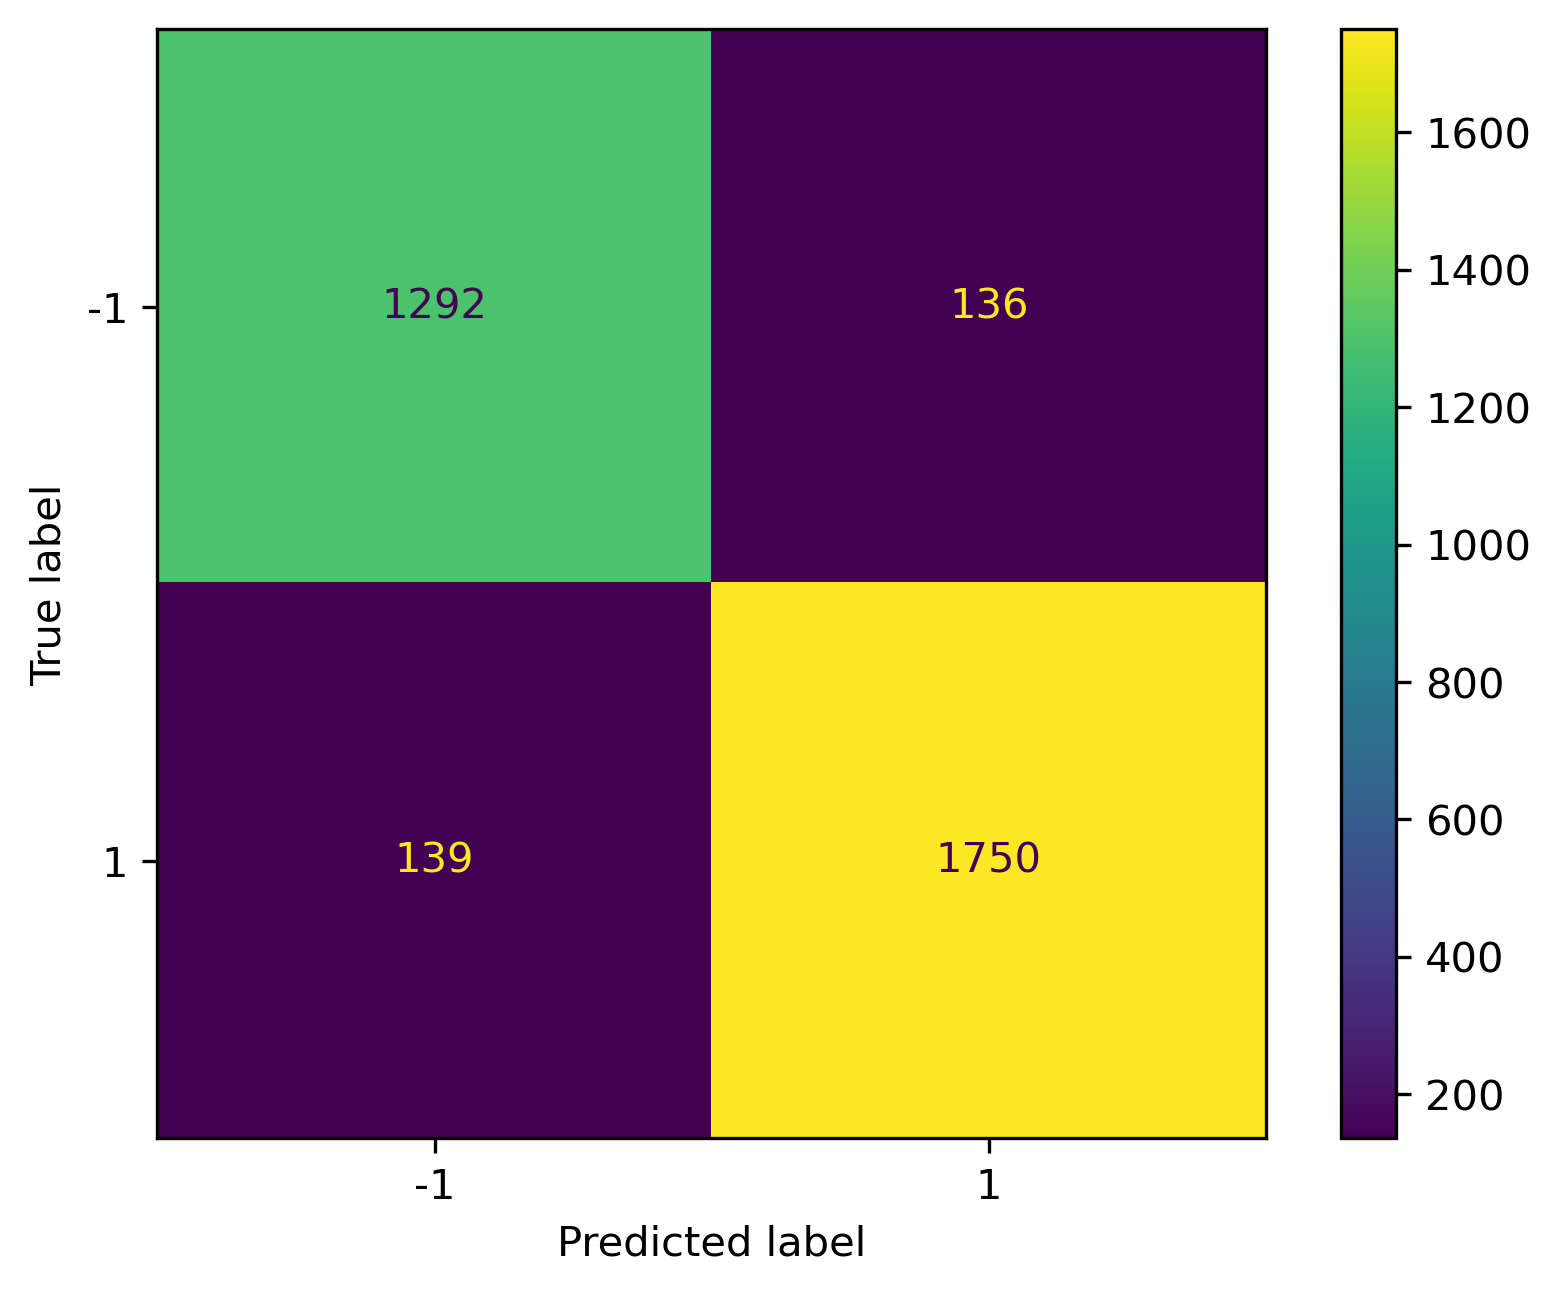

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, prediction)
cmd = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
cmd.plot()

cm_p = confusion_matrix(y_test, prediction_pruned)
cmd_p = ConfusionMatrixDisplay(cm_p, display_labels=model_pruned.classes_)
cmd_p.plot()